Daily Data Stream from 3 different subreddits : r/Spotify , r/popheads, r/music

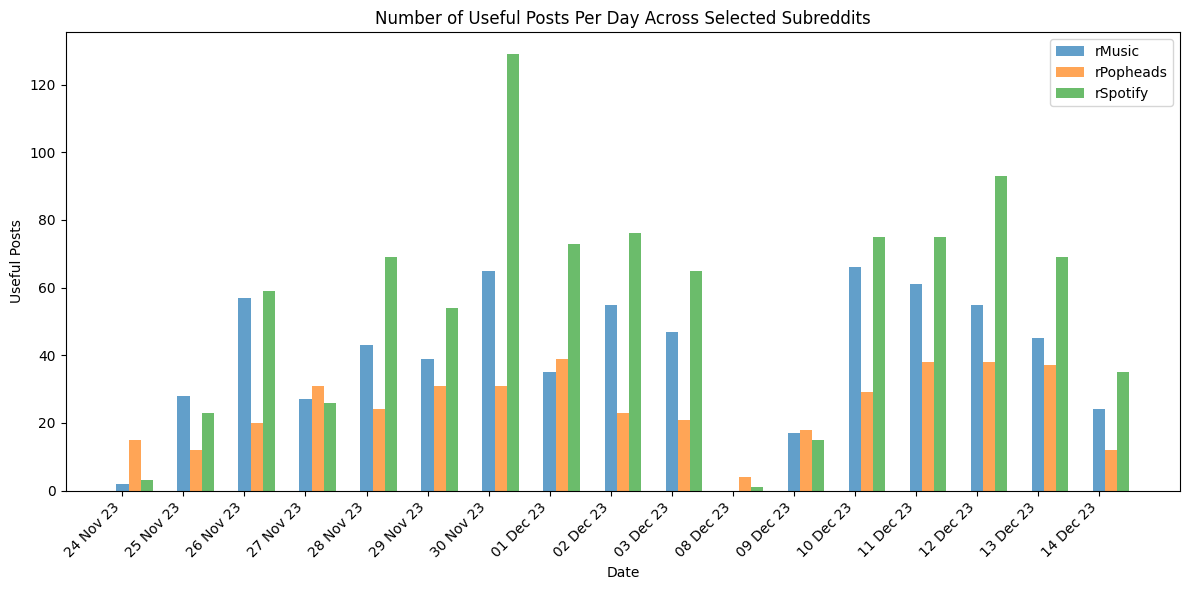

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client.chestnut
collections = ['rMusic', 'rSpotify', 'rPopheads']
output_path = '/home/dshetty3/project-1-implementation-chestnut/static/'

all_data = pd.DataFrame()

for collection_name in collections:
    collection = db[collection_name]
    cursor = collection.find({}, {"_id": 0, "created_date": 1, "post": 1})

    data = [{"collection": collection_name, "created_date": post.get("created_date"), "post": post.get("post")} for post in cursor]
    collection_df = pd.DataFrame(data)
    all_data = pd.concat([all_data, collection_df], ignore_index=True)

all_data['created_date'] = pd.to_datetime(all_data['created_date'])

all_data['date'] = all_data['created_date'].dt.strftime('%d %b %y')  

dates_to_exclude = ['16 Nov 23', '30 Jul 22', '02 Nov 23']
all_data_filtered = all_data[~all_data['date'].isin(dates_to_exclude)]

all_data_filtered = all_data_filtered.copy()
all_data_filtered['date'] = pd.to_datetime(all_data_filtered['date'], format='%d %b %y')

all_data_filtered = all_data_filtered.sort_values(by='date')

daily_post_counts = all_data_filtered.groupby(['collection', 'date']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

bar_width = 0.2 
bar_positions = range(len(daily_post_counts.columns))

for i, subreddit in enumerate(daily_post_counts.index):
    plt.bar(
        [pos + i * bar_width for pos in bar_positions],
        daily_post_counts.loc[subreddit],
        width=bar_width,
        label=subreddit,
        alpha=0.7
    )

plt.title('Number of Useful Posts Per Day Across Selected Subreddits')
plt.xlabel('Date')
plt.ylabel('Useful Posts')
plt.legend()
plt.xticks(bar_positions, daily_post_counts.columns.strftime('%d %b %y'), ha='right', rotation=45)
plt.grid(False) 

plt.tight_layout()
background_color = '#F0F0F0'  # Use a color code or a name for the color

plt.savefig('static/research1.png', transparent=True, facecolor=background_color)
plt.show()
plt.close()




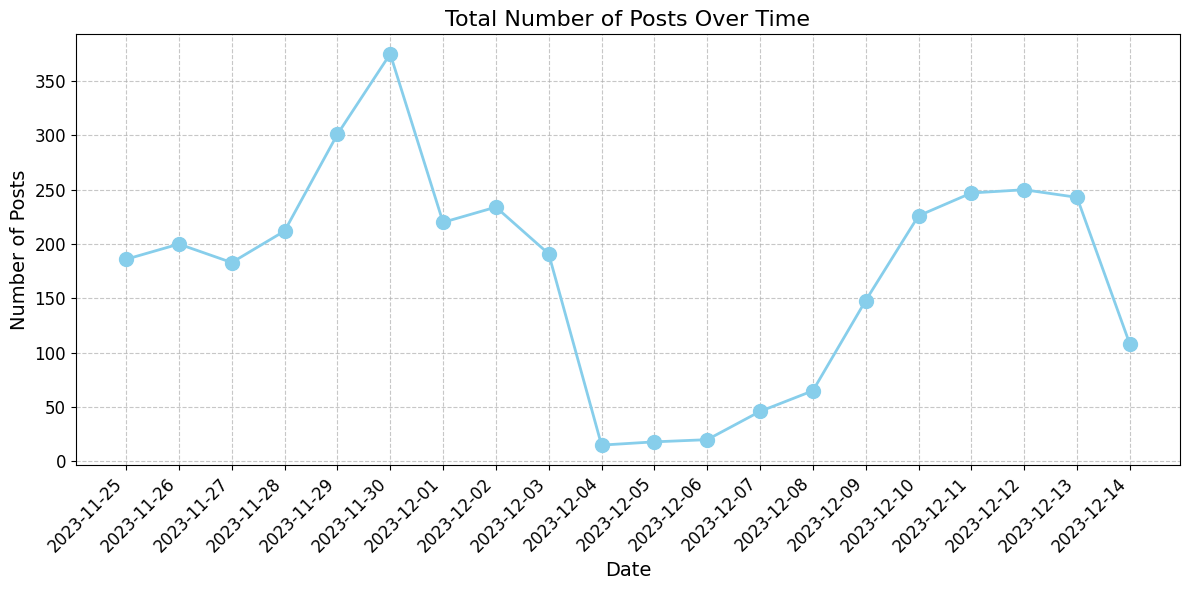

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient


conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts
output_path = '/home/dshetty3/project-1-implementation-chestnut/static/'

cursor = collection.find({})
data = list(cursor)


df = pd.DataFrame(data)
df['created_date'] = pd.to_datetime(df['created_date'])
start_date = pd.to_datetime('2023-11-25')  
num_days = 20
dfs = []
for i in range(num_days):
    date_filter = start_date + pd.DateOffset(days=i)
    filtered_data = df[df['created_date'].dt.date == date_filter.date()]
    num_posts = filtered_data.shape[0]
    date_str = date_filter.strftime("%Y-%m-%d")  
    dfs.append(pd.DataFrame({'date': [date_str], 'num_posts': [num_posts]}))


result_df = pd.concat(dfs, ignore_index=True)
result_df = result_df.sort_values(by=['date'])

plt.figure(figsize=(12, 6))
plt.plot(result_df['date'], result_df['num_posts'], marker='o', linestyle='-', color='skyblue', linewidth=2, markersize=10)

plt.title('Total Number of Posts Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('static/research2.png')
plt.show()


Research Ques 1: Is there a correlation between the level of activity on artist-specific subreddits (e.g., official subreddits) and the artist's success on Spotify, measured by metrics such as number of top hits and overall popularity?

The approach here I went through is by collecting the popularity of the artist whose songs are on the top daily hits charts: we get from spotify GET artist_details api and and plot the below graph. Now here, we have x-axis represents the artists who are trending in the top daily list playlist (in order) and y-axis represents the popularity on spotify - between 0 and 100; 100 being the most popular, it depends on the popularity of the artists tracks.

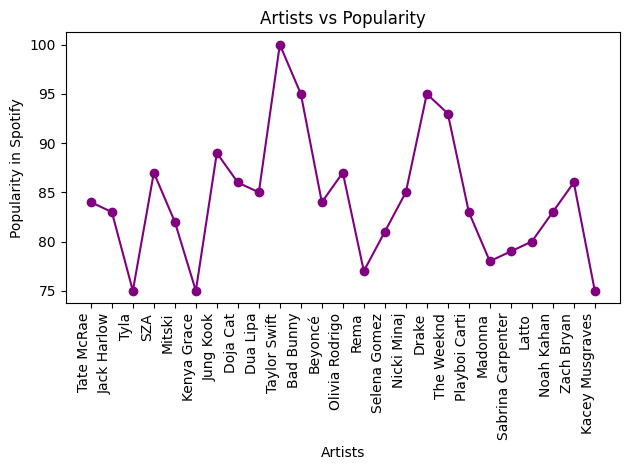

In [3]:
import matplotlib.pyplot as plt
import json
import pymongo

comments_by_artist = {}
conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_details
output_path = '/home/dshetty3/project-1-implementation-chestnut/static/'


artists_data = list(collection.find({}))

artist_names = [artist["name"] for artist in artists_data]
popularity_scores = [artist["popularity"] for artist in artists_data]

plt.plot(artist_names, popularity_scores, marker='o', linestyle='-', color='purple')
plt.xlabel('Artists')
plt.ylabel('Popularity in Spotify')
plt.title('Artists vs Popularity')
plt.xticks(rotation=90, ha='right')
plt.grid(False)  
plt.tight_layout()
plt.savefig('static/research3.png')
plt.show()
plt.close()

Further, I have collected the posts from earch artists official subreddits and have plotted a graph for fan engagagements in their subreddit and how does it change over the time and why does it change 

MOST COMMON REASONS
- a new song from the album
- tour fan threads
- social and public appearences (paparazzi) 
and many more....

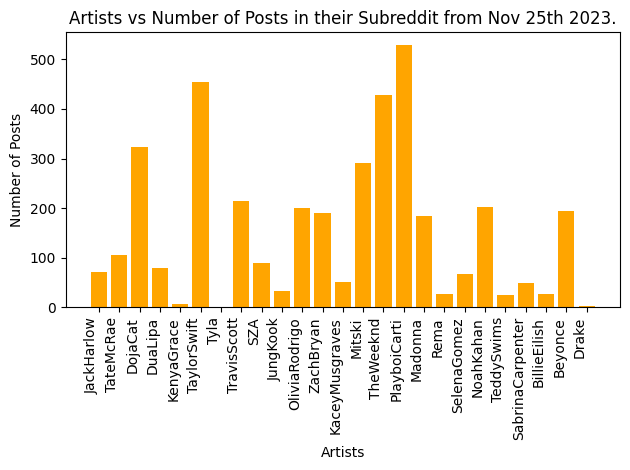

In [4]:
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import pymongo

comments_by_artist = {}
conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"]
    artist_post_counts[artist_name] += 1

artists = list(artist_post_counts.keys())
post_counts = list(artist_post_counts.values())

plt.bar(artists, post_counts, color='orange')
plt.xlabel('Artists')
plt.ylabel('Number of Posts')
plt.title('Artists vs Number of Posts in their Subreddit from Nov 25th 2023.')
plt.xticks(rotation=90, ha='right')
plt.grid(False)  
plt.tight_layout()
plt.savefig('static/research4.png')
plt.show()
plt.close()

Now here, we will be looking out whether there is a correlation in the number of posts in their subreddits which makes an impact on their populartiy on Spotify by plotting a dual-axis bar and line chart which will be most convinient for us to study and understand.

Moving on, we are calculating the pearson coefficient coefficient between popularity scores and the number of posts.

Artists like "Taylor Swift," "Travis Scott," and "The Weeknd" have high popularity scores, indicating a strong presence or following.
"playboicarti" has both a high popularity score and the highest number of posts, suggesting a combination of popularity and active discussion.
"Kenya Grace" has a low number of posts, indicating a comparatively lower level of discussion or content related to this artist despite having a popularity score of 76.

If the coefficient is positive, it suggests a positive correlation (as the number of posts increases, popularity tends to increase).

Correlation Coefficient: 0.46406173844226845
P-value: 0.034079074691701156


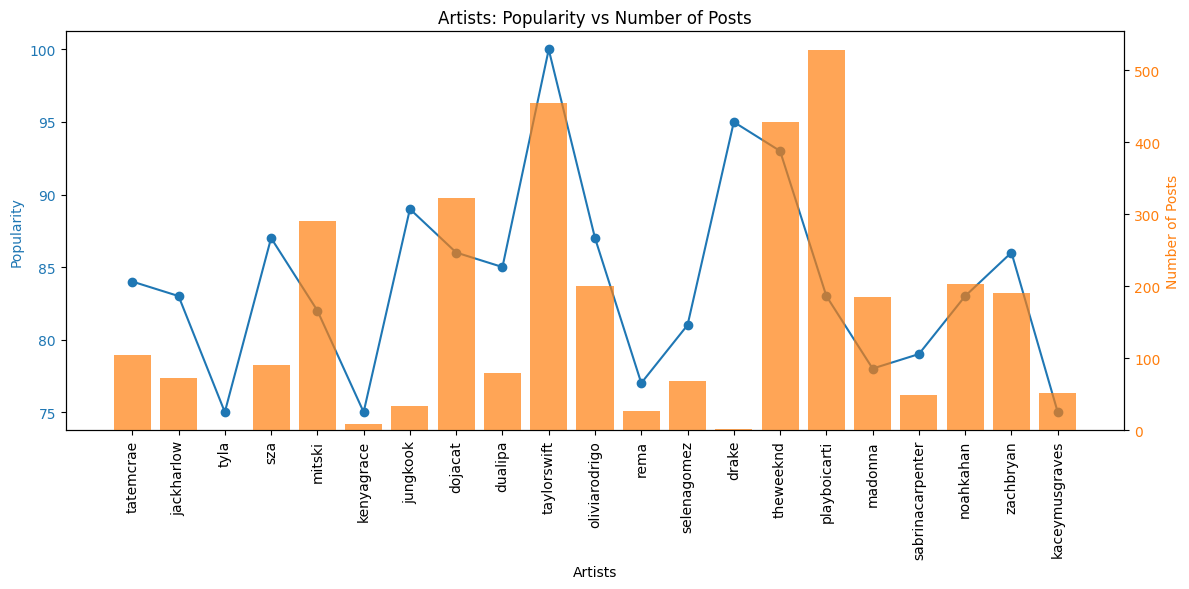

In [5]:
import matplotlib.pyplot as plt
import json
import pymongo
from collections import defaultdict
from scipy.stats import pearsonr

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut

artists_details_collection = db.artists_details
artists_posts_collection = db.artists_posts

artists_details_data = list(artists_details_collection.find({}))
artist_names = [artist["name"].lower().replace(" ", "") for artist in artists_details_data]

collection = db.artists_posts
artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "")
    artist_post_counts[artist_name] += 1

unique_artists_details = set(artist_names)
unique_artists_posts = set(artist_post_counts.keys())

common_artists = list(unique_artists_details.intersection(unique_artists_posts))
common_artists.sort(key=lambda x: artist_names.index(x))

popularity_scores = [artist["popularity"] for artist in artists_details_data if artist["name"].lower().replace(" ", "") in common_artists]
post_counts = [artist_post_counts[artist] for artist in common_artists]

#print("Unique Popularity Scores:", set(popularity_scores))
#print("Unique Post Counts:", set(post_counts))

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Artists')
ax1.set_ylabel('Popularity', color=color)
ax1.plot(common_artists, popularity_scores, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Posts', color=color)
ax2.bar(common_artists, post_counts, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.tight_layout()

# Correlation analysis starts here
if len(popularity_scores) > 1 and len(post_counts) > 1:
    correlation_coefficient, p_value = pearsonr(popularity_scores, post_counts)
    print(f"Correlation Coefficient: {correlation_coefficient}")
    print(f"P-value: {p_value}")
else:
    print("Correlation coefficient is not defined due to constant input array(s).") 

plt.title('Artists: Popularity vs Number of Posts')
plt.xticks(rotation='vertical', ha='right')
plt.tight_layout()
plt.savefig('static/research5.png')
plt.show()
plt.close()


Lets plot, analyze and visualizes sentiment scores along with popularity and post counts for a set of artists.

In the below graph some of the artists have a neutral sentiment score even with their song bein released and being on top of the charts for weeks and some have maintained the score with respect to their popularity (fan following, ongoing tour, album drop etc)

Artists such as Taylor Swift has been breaking records with her ongoing ERAs and her high profile relationship news with Travis Kelce which leads to the content of posts related to her being more positive which has maintained her popularity.

Even though Playboy Carti have a highest number of posts (colab with popular artists such as TheWeeknd and Madonna for a song), the sentiment score is 0, which suggests that they have neutral sentiments in their posts. The sentiments in their posts is neither strongly positve or negative.
Tyla too has neutral sentiments due to collab with Travis Scott

Jack Harlow, ranking in top charts for 4 consecutive days with new songhas a diverse sentiments - postive but not high (mix of negative as well).


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dshetty3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


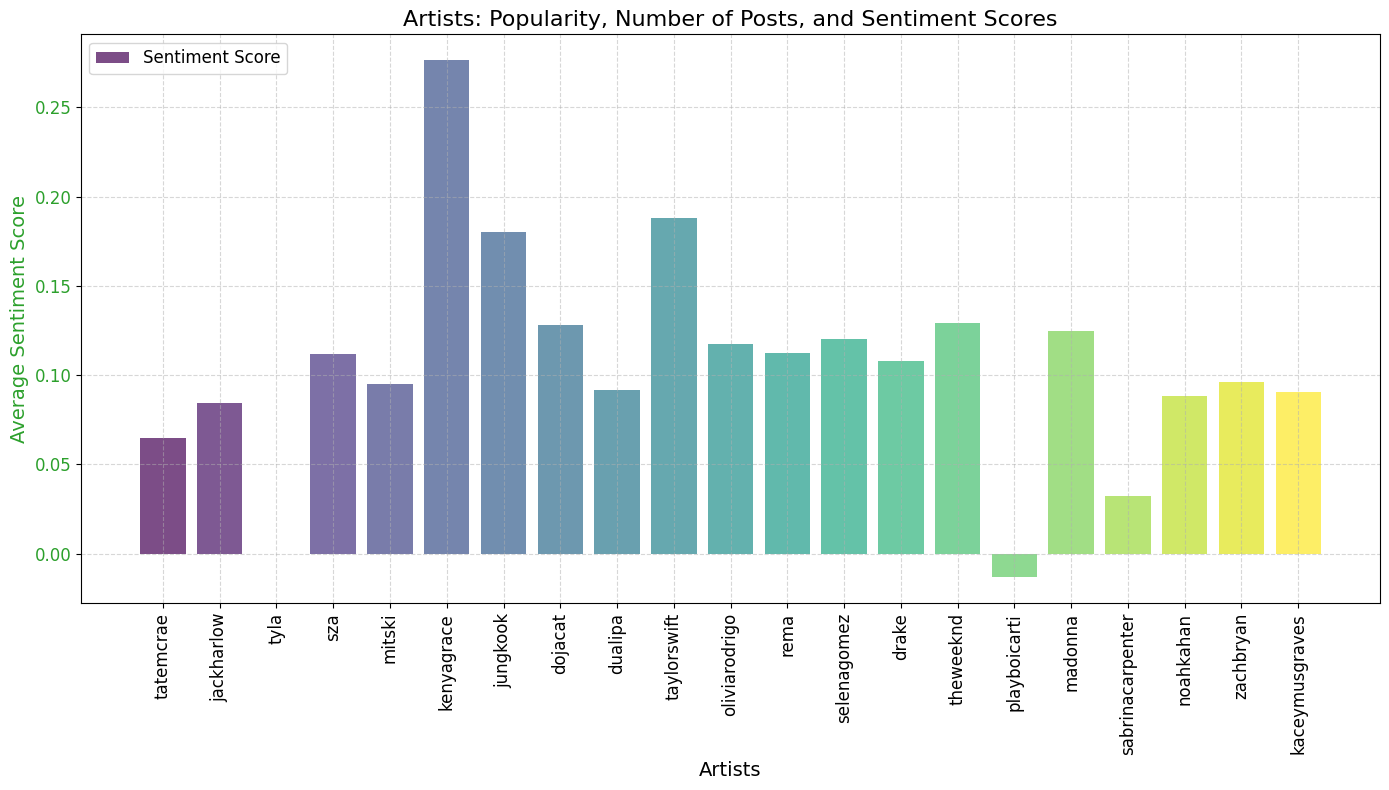

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pymongo
from collections import defaultdict
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
import numpy as np

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/', serverSelectionTimeoutMS=60000)
db = conn.chestnut

artists_details_collection = db.artists_details
artists_posts_collection = db.artists_posts

artists_details_data = list(artists_details_collection.find({}))
artist_names = [artist["name"].lower().replace(" ", "") for artist in artists_details_data]  

collection = db.artists_posts
artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "") 
    artist_post_counts[artist_name] += 1

unique_artists_details = set(artist_names)  
unique_artists_posts = set(artist_post_counts.keys())

common_artists = list(unique_artists_details.intersection(unique_artists_posts))

common_artists.sort(key=lambda x: artist_names.index(x))

popularity_scores = [artist["popularity"] for artist in artists_details_data if artist["name"].lower().replace(" ", "") in common_artists]
post_counts = [artist_post_counts[artist] for artist in common_artists]

nltk.download('vader_lexicon') 
sia = SentimentIntensityAnalyzer()

post_sentiments = defaultdict(list)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "")
    text = post["post"]
    sentiment_score = sia.polarity_scores(text)["compound"]
    post_sentiments[artist_name].append(sentiment_score)

average_sentiments = {artist: sum(scores) / len(scores) for artist, scores in post_sentiments.items()}

fig, ax3 = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(common_artists)))

ax3.set_xlabel('Artists', fontsize=14)
ax3.set_ylabel('Average Sentiment Score', color='tab:green', fontsize=14)
ax3.bar(common_artists, [average_sentiments[artist] for artist in common_artists], color=colors, alpha=0.7)

ax3.tick_params(axis='y', labelcolor='tab:green', labelsize=12)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.grid(True, linestyle='--', alpha=0.5)

plt.title('Artists: Popularity, Number of Posts, and Sentiment Scores', fontsize=16)

plt.legend(['Sentiment Score'], loc='upper left', fontsize=12)

plt.tight_layout() 
plt.savefig('static/research6.png')
plt.show()
plt.close()

                                        --------- RESEARCH QUESTION 1 DONE --------

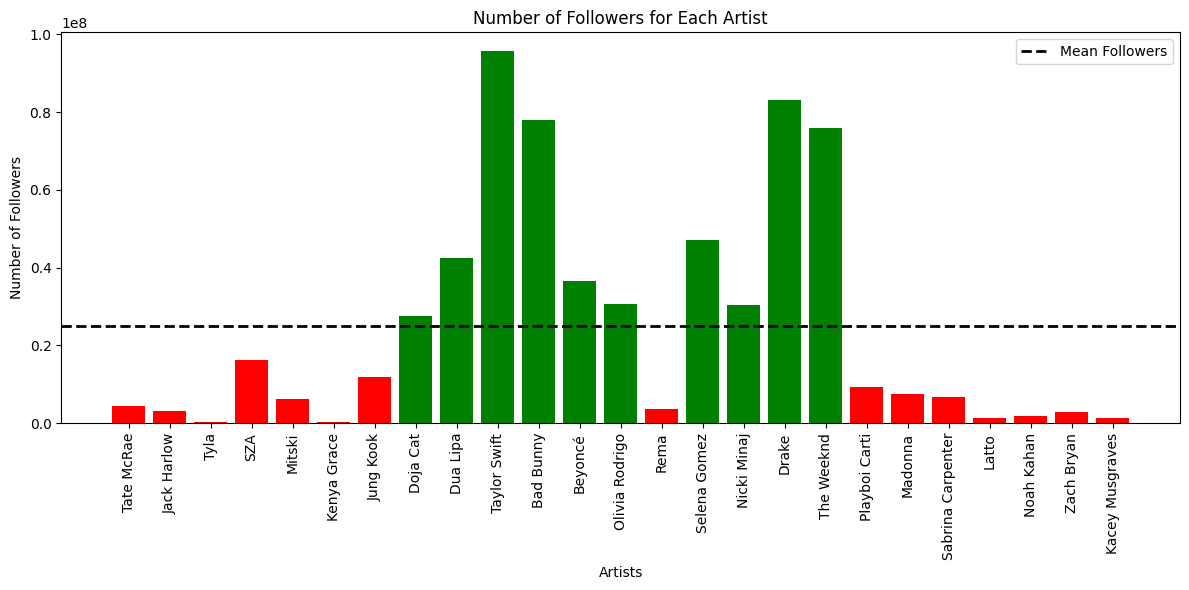

Mean Absolute Error: 26530077.72028349
Mean Squared Error: 1007792137961358.8
Root Mean Squared Error: 31745742.044585425


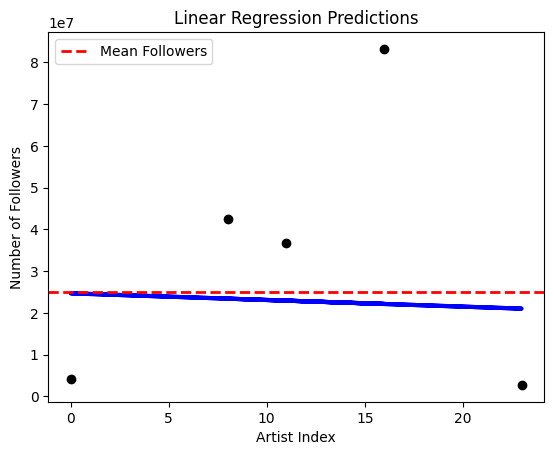

In [7]:
import matplotlib.pyplot as plt
import pymongo
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_details

artists_data = list(collection.find({}))

artists = [artist['name'] for artist in artists_data]
followers = [artist['followers']['total'] for artist in artists_data]

mean_followers = np.mean(followers)

colors = ['green' if follower > mean_followers else 'red' for follower in followers]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(artists, followers, color=colors)


ax.axhline(mean_followers, color='black', linestyle='--', linewidth=2, label='Mean Followers')

ax.set_xlabel('Artists')
ax.set_ylabel('Number of Followers')
ax.set_title('Number of Followers for Each Artist')
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig('static/research7.png')
plt.show()

followers = [artist['followers']['total'] for artist in artists_data]

artist_indices = list(range(len(artists_data)))

df = pd.DataFrame({'ArtistIndex': artist_indices, 'Followers': followers})

X = df[['ArtistIndex']]
y = df['Followers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred, squared=False))

plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.axhline(mean_followers, color='red', linestyle='--', linewidth=2, label='Mean Followers')
plt.xlabel('Artist Index')
plt.ylabel('Number of Followers')
plt.title('Linear Regression Predictions')
plt.legend()

plt.show()




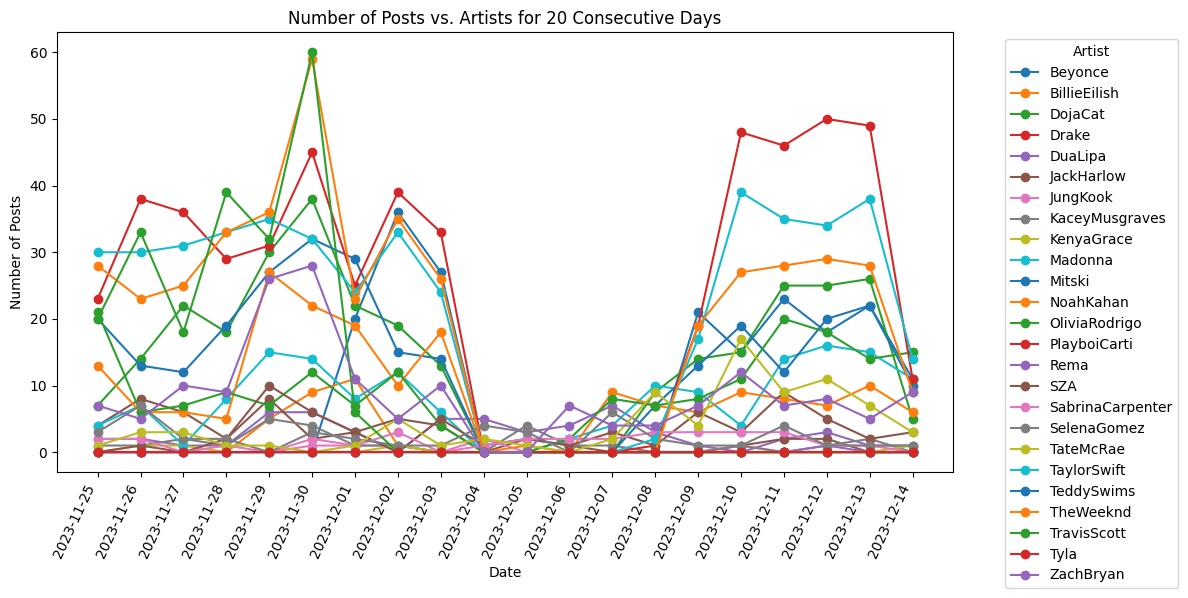

In [8]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

cursor = collection.find({})
data = list(cursor)

df = pd.DataFrame(data)

df['created_date'] = pd.to_datetime(df['created_date'])

unique_artists = df['artist'].unique()

start_date = pd.to_datetime('2023-11-25')  
num_days = 20

dfs = []

for artist in unique_artists:
   for i in range(num_days):
        date_filter = start_date + pd.DateOffset(days=i)
        filtered_data = df[(df['created_date'].dt.date == date_filter.date()) & (df['artist'] == artist)]

        num_posts = filtered_data.shape[0]

        date_str = date_filter.strftime("%Y-%m-%d")  
        dfs.append(pd.DataFrame({'date': [date_str], 'artist': [artist], 'num_posts': [num_posts]}))

result_df = pd.concat(dfs, ignore_index=True)

result_df = result_df.sort_values(by=['date'])

pivot_df = result_df.pivot(index='date', columns='artist', values='num_posts').fillna(0)

plt.figure(figsize=(12, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title(f'Number of Posts vs. Artists for {num_days} Consecutive Days')
plt.xticks(rotation=65, ha='right') 
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# for index, row in result_df.iterrows():
#     print(f"{row['date']} - {row['artist']}: {row['num_posts']} posts")
plt.savefig('static/research8.png')
plt.show()



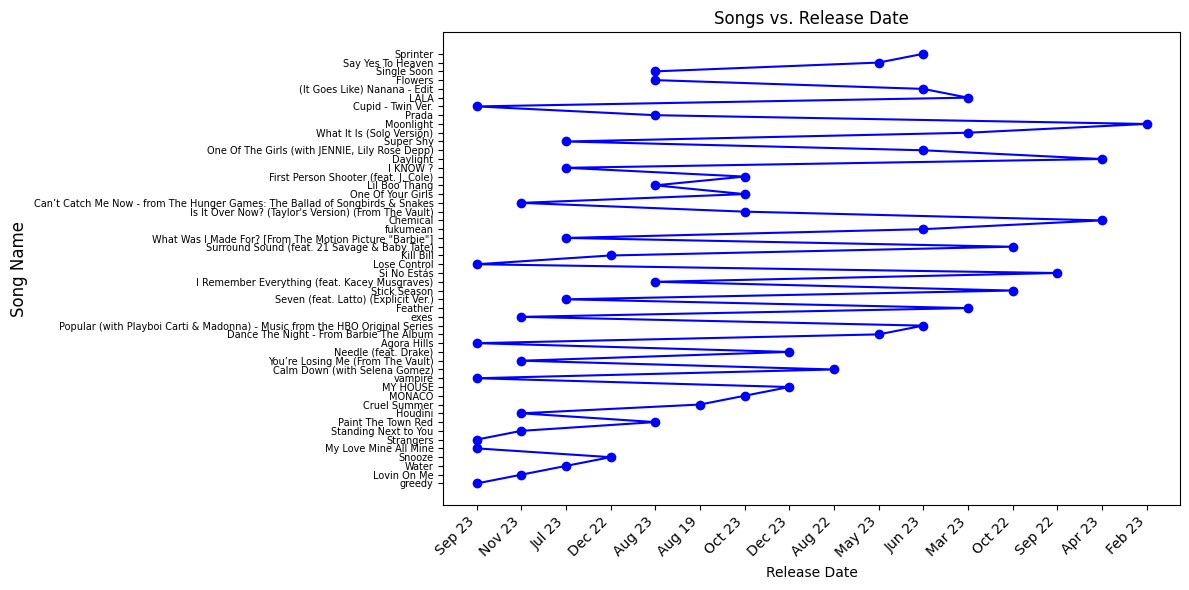

In [9]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
from datetime import datetime

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client.chestnut
collection = db.top_hits

cursor = collection.find({})
data = list(cursor)

song_names = [entry['track']['name'] for entry in data]
release_dates = [datetime.strptime(entry['track']['album']['release_date'], "%Y-%m-%d") for entry in data]
formatted_dates = [date.strftime("%b %y") for date in release_dates]

plt.figure(figsize=(12, 6))
plt.plot(formatted_dates, song_names, marker='o', linestyle='-', color='b')
plt.title('Songs vs. Release Date')
plt.xlabel('Release Date')
plt.ylabel('Song Name', fontsize=12)
plt.xticks(rotation=45, ha="right")  
plt.tick_params(axis='y', labelsize=7) 
plt.tight_layout()
plt.savefig('static/research9.png')
plt.show()


In [10]:
import pymongo
from prettytable import PrettyTable

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.top_hits  

cursor = collection.find({})

artist_songs = {}

for document in cursor:
    if "track" in document:
        track_info = document["track"]
        
        artist_name = track_info["artists"][0]["name"]  
        song_name = track_info["name"]
        
    
        if artist_name not in artist_songs:
            artist_songs[artist_name] = []
        artist_songs[artist_name].append(song_name)

table = PrettyTable()
table.field_names = ["Artist", "Song"]

for artist, songs in artist_songs.items():
    song_list = "\n".join(songs)
    table.add_row([artist, song_list])

print(table[:20])


+-------------------+------------------------------------------------------------------------------+
|       Artist      |                                     Song                                     |
+-------------------+------------------------------------------------------------------------------+
|     Tate McRae    |                                    greedy                                    |
|                   |                                     exes                                     |
|    Jack Harlow    |                                 Lovin On Me                                  |
|        Tyla       |                                    Water                                     |
|        SZA        |                                    Snooze                                    |
|                   |                                  Kill Bill                                   |
|       Mitski      |                            My Love Mine All Mine                     

+---------------+--------------------------------------------------------------------------------------------------------------------+--------------------+
|  Artist Name  |                                                     Post Title                                                     | Number of Comments |
+---------------+--------------------------------------------------------------------------------------------------------------------+--------------------+
|  TaylorSwift  |                                    The Eras Tour Megathread: São Paulo, Brazil                                     |       10208        |
| OliviaRodrigo |                                            'GUTS World Tour' Megathread                                            |        4718        |
|  TaylorSwift  |                             Football (Taylor's Version) - Bills vs. Chiefs Megathread                              |        1939        |
|  TaylorSwift  |                                        New old

/tmp/ipykernel_969879/2385464043.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=comment_counts, y=post_titles_with_artist, palette="viridis", edgecolor="black")


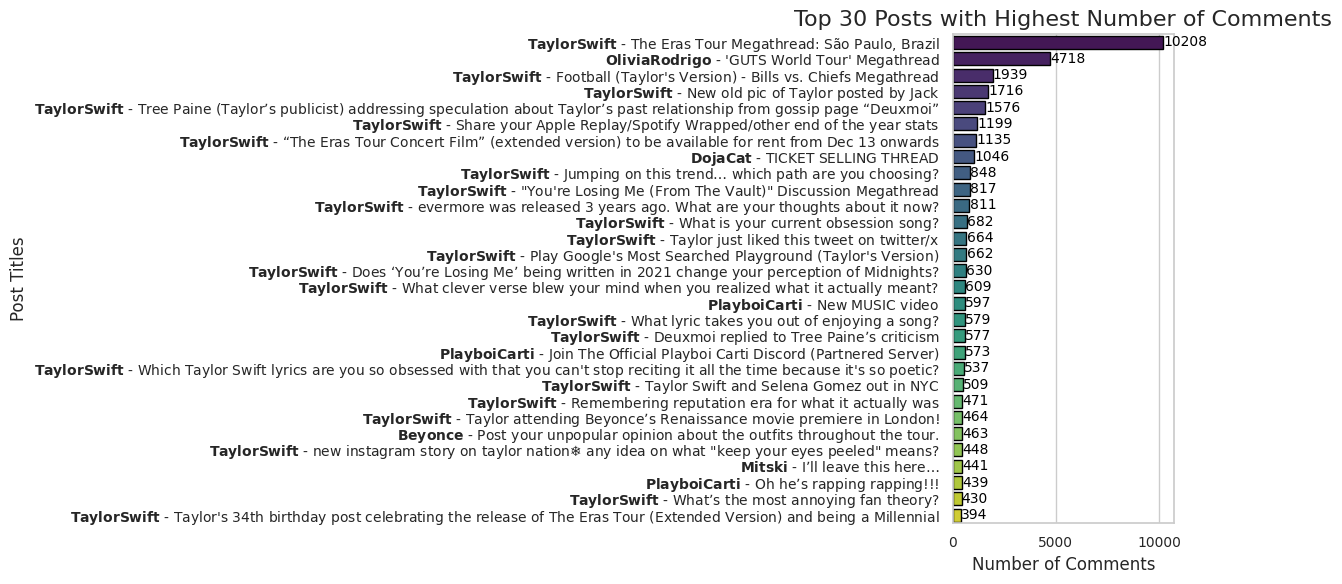

In [11]:
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

cursor = collection.find().sort("number_of_comments", pymongo.DESCENDING).limit(30)

post_titles_with_artist = []
comment_counts = []

table = PrettyTable()
table.field_names = ["Artist Name", "Post Title", "Number of Comments"]

for post in cursor:
    artist_name = post["artist"]  
    post_title = post["post"]
    number_of_comments = post["number_of_comments"]
    formatted_artist = r"$\mathbf{" + artist_name + "}$"
    
    post_title_with_artist = f"{formatted_artist} - {post_title}"
    
    post_titles_with_artist.append(post_title_with_artist)
    comment_counts.append(number_of_comments)
    
    table.add_row([artist_name, post_title, number_of_comments])

table.float_format = "0.02"

print(table[:20])

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=comment_counts, y=post_titles_with_artist, palette="viridis", edgecolor="black")

for bar, count, title_with_artist in zip(bars.patches, comment_counts, post_titles_with_artist):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2, f'{count}', ha='left', va='center', fontsize=10, color='black')
plt.title('Top 30 Posts with Highest Number of Comments', fontsize=16)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Post Titles', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.savefig('static/research9.png')
plt.show()


[nltk_data] Downloading package punkt to /home/dshetty3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dshetty3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+----------+-----------+
|   Word   | Frequency |
+----------+-----------+
|   song   |    378    |
|  songs   |    331    |
|  music   |    302    |
| spotify  |    283    |
|  taylor  |    245    |
|   new    |    244    |
| playlist |    191    |
|  album   |    185    |
|   tour   |    184    |
|  carti   |    176    |
+----------+-----------+


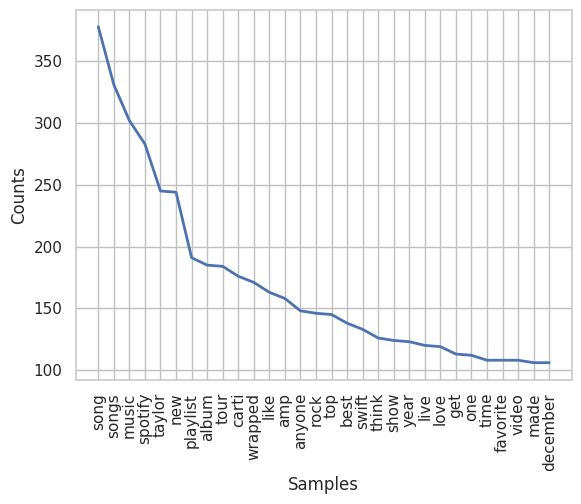

<Figure size 1200x600 with 0 Axes>

In [12]:
import pymongo
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('stopwords')

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut

subreddits = ['rSpotify', 'rMusic', 'rPopheads', 'artists_posts']

all_titles = ''
for subreddit in subreddits:
    collection = db[subreddit]
    posts = collection.find({}, {"post": 1, "_id": 0})
    all_titles += ' '.join([post['post'] for post in posts])

tokens = word_tokenize(all_titles)

stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

fdist = FreqDist(filtered_tokens)

table = PrettyTable(["Word", "Frequency"])

for word, frequency in fdist.most_common(10):
    table.add_row([word, frequency])
    #print(f"{word}: {frequency}")

print(table)

fdist.plot(30, cumulative=False)
plt.figure(figsize=(12, 6))
plt.savefig('static/research10.png')
plt.show()


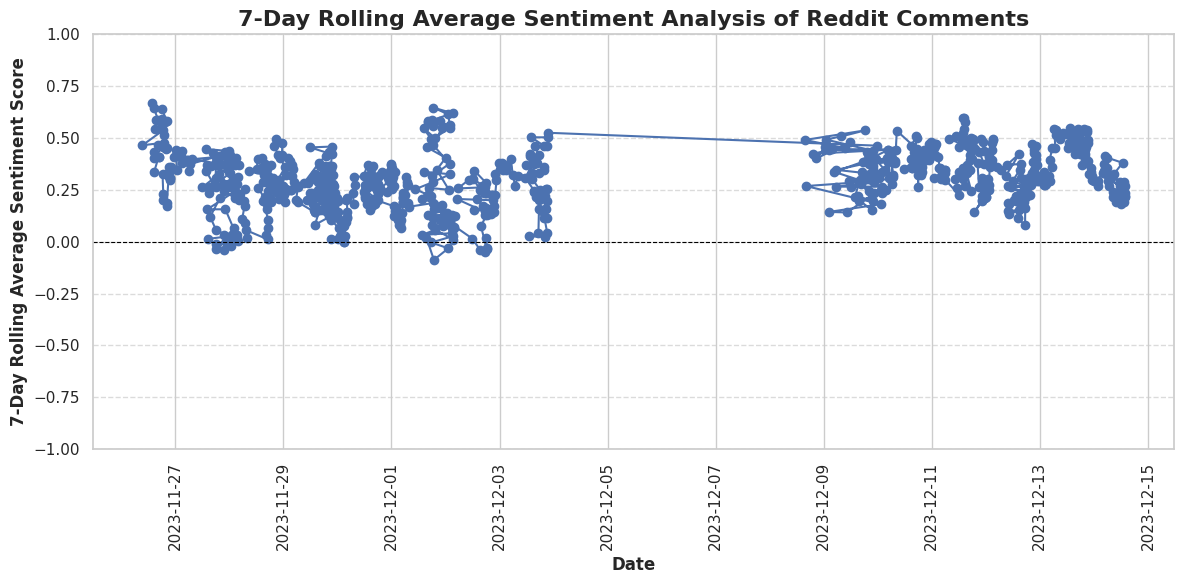

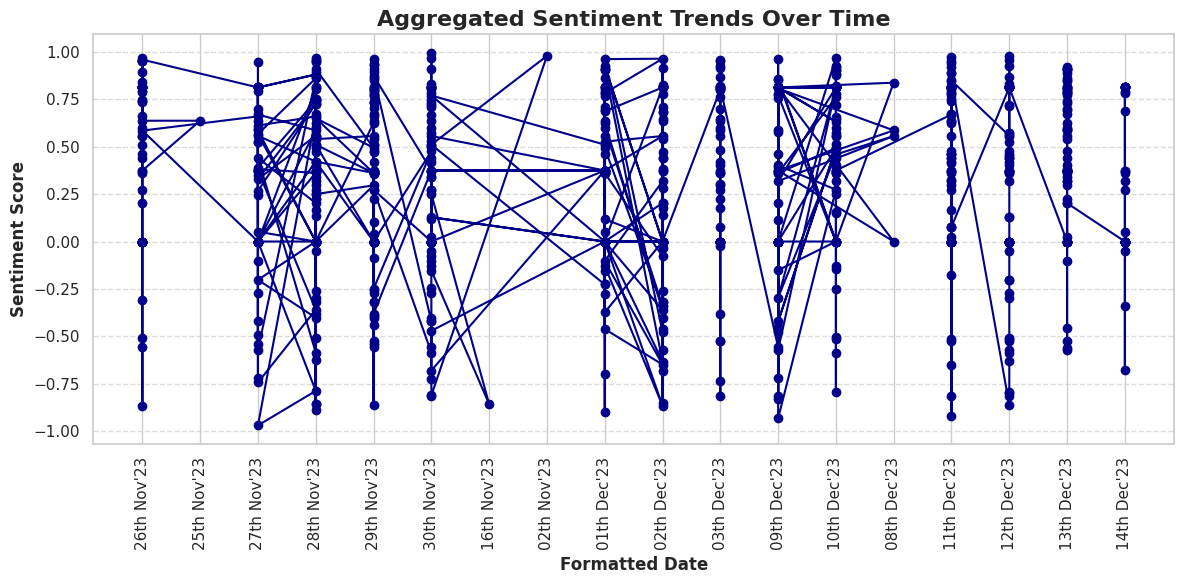

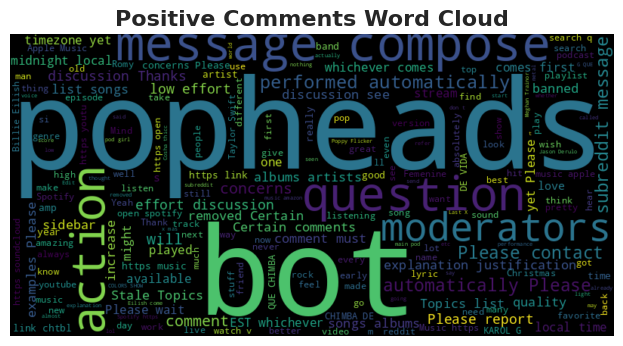

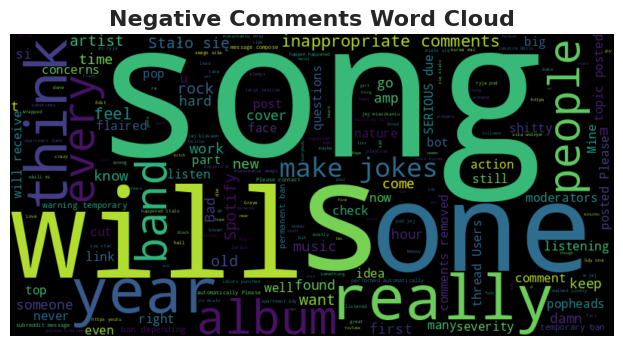

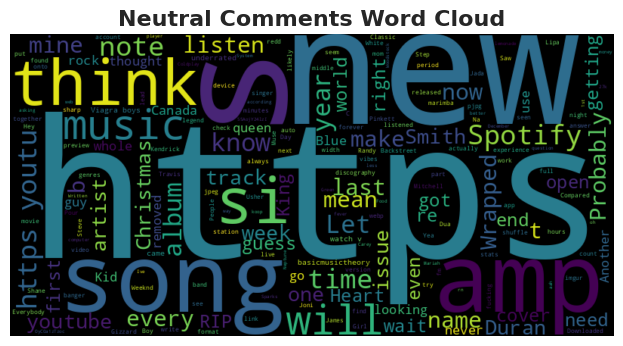

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from pymongo import MongoClient
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

client = MongoClient('mongodb://127.0.0.1:27017/')

db = client.chestnut
collection = db.rComments

comments_data = list(collection.find({}, {"comment_body": 1, "comment_created_date": 1, "_id": 0}))

comments = [comment["comment_body"] for comment in comments_data]
dates = [comment["comment_created_date"] for comment in comments_data]

sia = SentimentIntensityAnalyzer()

sentiments = [sia.polarity_scores(comment)["compound"] for comment in comments]

dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S UTC') for date in dates]

formatted_dates = [date.strftime('%dth %b\'%y') for date in dates]

df = pd.DataFrame({"Date": dates, "Formatted Date": formatted_dates, "Sentiment": sentiments})

df.set_index('Date', inplace=True)

df_filtered = df[df.index >= datetime(2023, 11, 25)]

rolling_avg_sentiments = df_filtered['Sentiment'].rolling(window=15).mean()

plt.figure(figsize=(12, 6))
plt.plot(rolling_avg_sentiments.index, rolling_avg_sentiments.values, marker='o', linestyle='-', color='b')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('7-Day Rolling Average Sentiment Score', fontsize=12, fontweight='bold')
plt.title('7-Day Rolling Average Sentiment Analysis of Reddit Comments', fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
plt.ylim([-1, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Sentiment'], marker='o', linestyle='-', color='darkblue')
plt.xlabel('Formatted Date', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Aggregated Sentiment Trends Over Time', fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

positive_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment > 0]
negative_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment < 0]
neutral_comments = [comment for comment, sentiment in zip(comments, sentiments) if sentiment == 0]

positive_wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_comments))
negative_wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_comments))
neutral_wordcloud = WordCloud(width=800, height=400).generate(' '.join(neutral_comments))

plt.plot(3, 1, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('static/research11.png')
plt.show()

plt.plot(3, 1, 1)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('static/research12.png')
plt.show()

plt.plot(3, 1, 1)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Comments Word Cloud', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('static/research13.png')
plt.show()




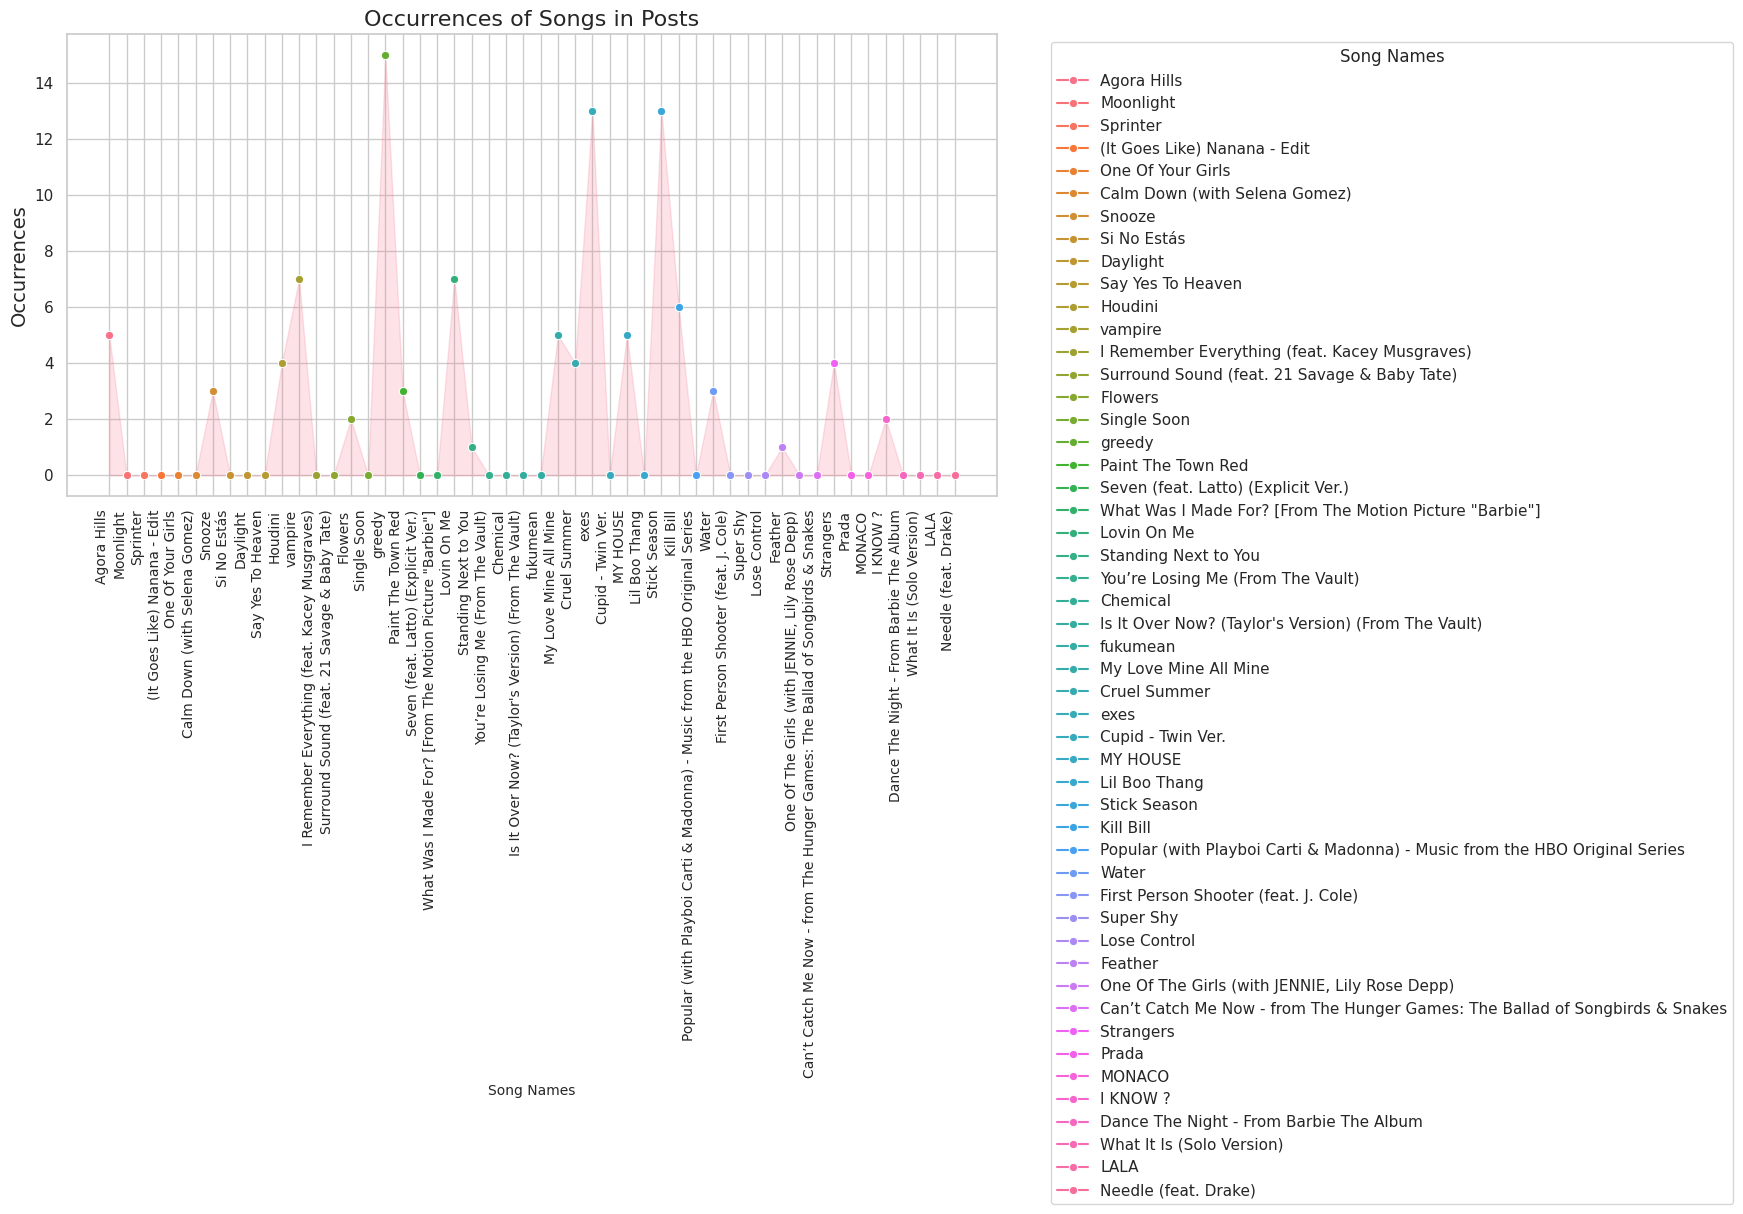

Songs with More Than One Occurrence:
Agora Hills: 5 occurrences
Snooze: 3 occurrences
Houdini: 4 occurrences
vampire: 7 occurrences
Flowers: 2 occurrences
greedy: 15 occurrences
Paint The Town Red: 3 occurrences
Lovin On Me: 7 occurrences
My Love Mine All Mine: 5 occurrences
Cruel Summer: 4 occurrences
exes: 13 occurrences
MY HOUSE: 5 occurrences
Stick Season: 13 occurrences
Kill Bill: 6 occurrences
Water: 3 occurrences
Strangers: 4 occurrences
I KNOW ?: 2 occurrences


In [14]:
from pymongo import MongoClient
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts
collection_spotify = db.top_hits

cursor = collection_spotify.find({})
song_names = [entry["track"]["name"] for entry in cursor]
unique_song_names = list(set(song_names))

posts_cursor = collection.find({})

song_occurrences = {song: 0 for song in unique_song_names}
for post_entry in posts_cursor:
    post_text = post_entry["post"]
    for song in unique_song_names:
        if song.lower() in post_text.lower():
            song_occurrences[song] += 1

table = [["Song Names", "Occurrences"]] + [[name, song_occurrences[name]] for name in unique_song_names]

table_format = "fancy_grid"
numalign = "center" 
stralign = "center"  

colors = sns.color_palette("husl", len(unique_song_names))

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
for i, song_name in enumerate(unique_song_names):
    sns.lineplot(x=[song_name], y=[song_occurrences[song_name]], marker='o', color=colors[i], label=song_name)

ax.fill_between(unique_song_names, [song_occurrences[song_name] for song_name in unique_song_names], color=colors[0], alpha=0.2)

ax.set_ylabel('Occurrences', fontsize=14)
ax.set_xlabel('Song Names', fontsize=10)
ax.set_title('Occurrences of Songs in Posts', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.legend(title='Song Names', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('static/research14.png', bbox_inches='tight')
plt.show()

multiple_occurrence_songs = [song for song, occurrences in song_occurrences.items() if occurrences > 1]


print("Songs with More Than One Occurrence:")
for song_name in multiple_occurrence_songs:
     print(f"{song_name}: {song_occurrences[song_name]} occurrences")


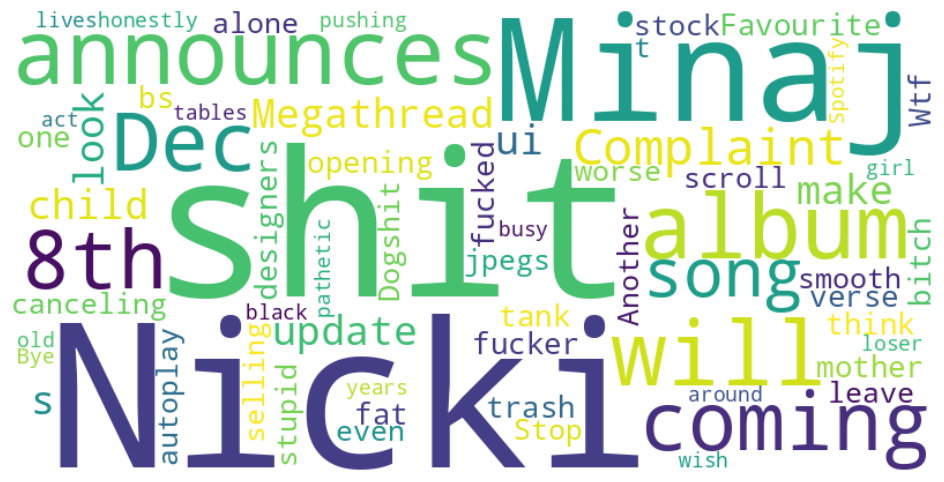

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pymongo import MongoClient

conn = MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.rHateComments

data = list(collection.find({}, {'post_title': 1, 'comment_body': 1}))

text = ' '.join([entry['post_title'] + ' ' + entry['comment_body'] for entry in data])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('static/research15.png')
plt.show()
